In [766]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import datetime

warnings.filterwarnings("ignore")

In [767]:
# read file which has game data from season 1995-96 to 2022-23

cols = ["season", "matchday", "date", "home", "h_goals", "a_goals", "away", "ftr"]
df = pd.read_csv("data.csv", names = cols)
df.head()

,season,matchday,date,home,h_goals,a_goals,away,ftr
0,1996,1,1995-08-19,Wimbledon,3,2,Bolton,H
1,1996,1,1995-08-19,Newcastle Utd,3,0,Coventry City,H
2,1996,1,1995-08-19,Manchester City,1,1,Tottenham,D
3,1996,1,1995-08-19,Aston Villa,3,1,Manchester Utd,H
4,1996,1,1995-08-19,Blackburn,1,0,QPR,H


In [768]:
# convert date from string to datetime
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

start = df.at[0, "date"].toordinal()

df["date_int"] = [df.at[i, "date"].toordinal()-start for i in range(len(df))]
# normalize date_int
df["date_int"] = (df["date_int"] - df["date_int"].min()) / (df["date_int"].max() - df["date_int"].min())

df.tail(10)

,season,matchday,date,home,h_goals,a_goals,away,ftr,date_int
10630,2023,38,2023-05-28,Crystal Palace,1,1,Nott'ham Forest,D,1.0
10631,2023,38,2023-05-28,Chelsea,1,1,Newcastle Utd,D,1.0
10632,2023,38,2023-05-28,Manchester Utd,2,1,Fulham,H,1.0
10633,2023,38,2023-05-28,Arsenal,5,0,Wolves,H,1.0
10634,2023,38,2023-05-28,Southampton,4,4,Liverpool,D,1.0
10635,2023,38,2023-05-28,Everton,1,0,Bournemouth,H,1.0
10636,2023,38,2023-05-28,Leicester City,2,1,West Ham,H,1.0
10637,2023,38,2023-05-28,Aston Villa,2,1,Brighton,H,1.0
10638,2023,38,2023-05-28,Leeds United,1,4,Tottenham,A,1.0
10639,2023,38,2023-05-28,Brentford,1,0,Manchester City,H,1.0


In [769]:
# convert ftr: h=0, d=1, a=2

results = ["H", "D", "A"]

ftr = []

for i, row in df.iterrows():
    ftr.append(results.index(row["ftr"]))
    
df["ftr"] = ftr

df.head()

,season,matchday,date,home,h_goals,a_goals,away,ftr,date_int
0,1996,1,1995-08-19,Wimbledon,3,2,Bolton,0,0.0
1,1996,1,1995-08-19,Newcastle Utd,3,0,Coventry City,0,0.0
2,1996,1,1995-08-19,Manchester City,1,1,Tottenham,1,0.0
3,1996,1,1995-08-19,Aston Villa,3,1,Manchester Utd,0,0.0
4,1996,1,1995-08-19,Blackburn,1,0,QPR,0,0.0


In [770]:
# assign each team a code

teams = pd.unique(df["home"]).tolist()

h = []
a = []

for i, row in df.iterrows():
    h.append(teams.index(row["home"]))
    a.append(teams.index(row["away"]))
    
df["h"] = h
df["a"] = a

test_df = df[df["season"] == 2023]
df = df[df["season"] != 2023]

df.head()

,season,matchday,date,home,h_goals,a_goals,away,ftr,date_int,h,a
0,1996,1,1995-08-19,Wimbledon,3,2,Bolton,0,0.0,0,11
1,1996,1,1995-08-19,Newcastle Utd,3,0,Coventry City,0,0.0,1,14
2,1996,1,1995-08-19,Manchester City,1,1,Tottenham,1,0.0,2,17
3,1996,1,1995-08-19,Aston Villa,3,1,Manchester Utd,0,0.0,3,13
4,1996,1,1995-08-19,Blackburn,1,0,QPR,0,0.0,4,15


In [771]:
teams_dfs = []

# venue = 0 if home, 1 if away, result = 0  if win, 1 if draw, 2 is loss
team_df_cols = ["date_int", "opponent", "venue", "goals", "opp_goals", "result"]

for i in range(len(teams)):
    
    team_df = pd.DataFrame([], columns = team_df_cols)   
    teams_dfs.append(team_df)

for index, row in df.iterrows():
    teams_dfs[row["h"]].loc[len(teams_dfs[row["h"]])] = [row["date_int"], row["a"], 0, row["h_goals"], row["a_goals"], row["ftr"]]
    teams_dfs[row["a"]].loc[len(teams_dfs[row["a"]])] = [row["date_int"], row["h"], 1, row["a_goals"], row["h_goals"], 2-row["ftr"]]
    
for team_df in teams_dfs:
    team_df["opponent"] = (team_df["opponent"]).astype(int)
    team_df["venue"] = (team_df["venue"]).astype(int)
    team_df["goals"] = (team_df["goals"]).astype(int)
    team_df["opp_goals"] = (team_df["opp_goals"]).astype(int)
    team_df["result"] = (team_df["result"]).astype(int)

In [772]:
# for i in range(len(teams)):
#     print(teams[i])
#     print(teams_dfs[i])

In [773]:
def rolling_stats(df, cols, n):
    new_col_names = [col_name+"_"+str(i+1) for col_name in cols for i in range(n) ]
    new_col_vals = []
    for col in cols:
        for i in range(n):
            new_col_vals.append([])
    
    for index, row in df.iterrows():
        if index >= n:
            for col_i in range(len(cols)):
                for i in range(1, n+1):
                    new_col_vals[col_i*n + i - 1].append(df.at[index-i, cols[col_i]])
        
    df = df.iloc[n:]
    
    for i in range(len(new_col_names)):
        df[new_col_names[i]] = new_col_vals[i]
    
    return df

In [774]:
rolling_avg_cols = ["goals", "opp_goals", "result"]

teams_dfs_new = []

for team_df in teams_dfs:
    team_df_new = team_df.copy(deep=True)
    # add rolling stats
    team_df_new = rolling_stats(team_df_new, rolling_avg_cols, 3)
    # one hot encoding for opponent
    team_df_new = pd.get_dummies(team_df_new, columns = ["opponent"], dtype=int)
    # add to list
    teams_dfs_new.append(team_df_new)

In [775]:
# for i in range(len(teams)):
#     print(teams[i])
#     print(teams_dfs_new[i])

In [776]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [777]:
train_dfs = []
valid_dfs = []

for team_df in teams_dfs_new:
    train, valid = train_test_split(team_df, test_size=0.2, shuffle=False)
    train_dfs.append(train)
    valid_dfs.append(valid)

In [778]:
Xs = []

for team_df in teams_dfs_new:
    cols = list(team_df.columns)
    X = list(filter(lambda x: x not in ["goals", "opp_goals", "result"], cols))
    Xs.append(X)
    
# y = ["goals", "opp_goals", "result"]
y = "result"

In [535]:
def plot_history(history):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    ax1.plot(history.history["loss"], label="loss")
    ax1.plot(history.history["val_loss"], label="val_loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Categorical crossentropy")
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(history.history["accuracy"], label="accuracy")
    ax2.plot(history.history["val_accuracy"], label="val_accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.grid(True)
    ax2.legend()
    
    plt.show()

In [603]:
def train_model(X_train, y_train, X_valid, y_valid, num_layers, num_nodes, dropout_prob, learning_rate, batch_size, epochs):    
    nn_model = tf.keras.Sequential()
    
    nn_model.add(tf.keras.layers.Dense(num_nodes, activation="relu", input_shape=(len(X_train.columns),)))
    
    for i in range(num_layers):
        nn_model.add(tf.keras.layers.Dropout(dropout_prob))
        nn_model.add(tf.keras.layers.Dense(num_nodes, activation="relu"))
        
    nn_model.add(tf.keras.layers.Dense(3, activation="softmax"))
    
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
    
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(X_valid, y_valid), use_multiprocessing=True)
    
    return nn_model, history

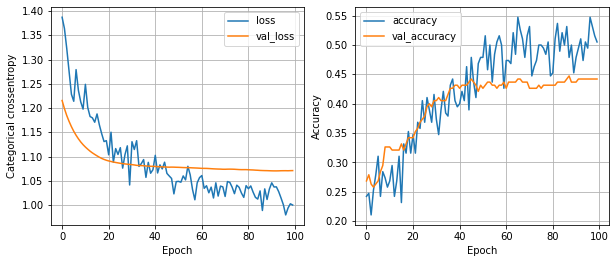

6/6 [==============================] - 0s 4ms/step - loss: 1.0711 - accuracy: 0.4421


[1.0711314678192139, 0.4421052634716034]

In [779]:
i = 1

train_df_temp = train_dfs[i]
l = len(train_df_temp)
train_df = train_df_temp.iloc[int(l*0.75):]

X_train = train_df[Xs[i]]
y_train = pd.get_dummies(train_df[y])

valid_df = valid_dfs[i]
X_valid = valid_df[Xs[i]]
y_valid = pd.get_dummies(valid_df[y])

model, history = train_model(X_train, y_train, X_valid, y_valid, 1, 32, 0.3, 0.0001, 19, 100)
plot_history(history)

model.evaluate(X_valid, y_valid)

In [780]:
teams_2023 = test_df["home"].unique()
teams_2023 = [teams.index(team) for team in teams_2023]

teams_2023

[24, 29, 17, 1, 10, 44, 18, 22, 13, 8, 3, 2, 7, 33, 9, 45, 47, 16, 6, 5]

In [608]:
jobs = 6 # it means number of cores
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [611]:
# train all teams models

models = {}
settings = {}

for i in teams_2023:
    
    least_val_loss = float("inf")
    least_val_model = None
    least_val_settings = {}
    epochs = 100
    
    train_df_temp = train_dfs[i]
    l = len(train_df_temp)
    
    valid_df = valid_dfs[i]
    X_valid = valid_df[Xs[i]]
    y_valid = pd.get_dummies(valid_df[y])
    
    print(i, teams[i], end = ": ")
    
    for split in [0,0.25,0.5]:
        
        train_df = train_df_temp.iloc[int(l*split):]
        X_train = train_df[Xs[i]]
        y_train = pd.get_dummies(train_df[y])
        
        for layers in [1, 2]:
            for num_nodes in [32, 64]:
                for dropout_prob in [0.1, 0.2]:
                    for learning_rate in [0.001, 0.0001]:
                        for batch_size in [12, 19, 38]:
                            model, history = train_model(X_train, y_train, X_valid, y_valid, layers, num_nodes, dropout_prob, learning_rate, batch_size, epochs)
#                             plot_history(history)
                            val_loss = model.evaluate(X_valid, y_valid)[0]
                            if val_loss < least_val_loss:
                                least_val_loss = val_loss
                                least_val_model = model
                                least_val_settings["split"] = split
                                least_val_settings["layers"] = layers
                                least_val_settings["num_nodes"] = num_nodes
                                least_val_settings["dropout_prob"] = dropout_prob
                                least_val_settings["learning_rate"] = learning_rate
                                least_val_settings["batch_size"] = batch_size
                                
    models[i] = least_val_model
    settings[i] = least_val_settings
    print("done")

3/3 [==============================] - 0s 2ms/step - loss: 1.1236 - accuracy: 0.4337


3/3 [==============================] - 0s 3ms/step - loss: 1.0986 - accuracy: 0.4458
done
4/4 [==============================] - 0s 2ms/step - loss: 1.0600 - accuracy: 0.3860


4/4 [==============================] - 0s 2ms/step - loss: 1.0795 - accuracy: 0.4298
done


7/7 [==============================] - 0s 1ms/step - loss: 1.0076 - accuracy: 0.5415


7/7 [==============================] - 0s 1ms/step - loss: 0.9660 - accuracy: 0.5610
done
6/6 [==============================] - 0s 2ms/step - loss: 1.0674 - accuracy: 0.4632


6/6 [==============================] - 0s 2ms/step - loss: 1.0749 - accuracy: 0.4474
done


3/3 [==============================] - 0s 3ms/step - loss: 1.0823 - accuracy: 0.3494


3/3 [==============================] - 0s 2ms/step - loss: 1.0448 - accuracy: 0.3976
done
2/2 [==============================] - 0s 4ms/step - loss: 1.0010 - accuracy: 0.5526


2/2 [==============================] - 0s 3ms/step - loss: 0.9805 - accuracy: 0.5789
done


7/7 [==============================] - 0s 2ms/step - loss: 1.0928 - accuracy: 0.4146


7/7 [==============================] - 0s 4ms/step - loss: 1.1054 - accuracy: 0.3805
done
4/4 [==============================] - 0s 4ms/step - loss: 1.1034 - accuracy: 0.3596


4/4 [==============================] - 0s 2ms/step - loss: 1.1194 - accuracy: 0.3421
done


7/7 [==============================] - 0s 2ms/step - loss: 1.0808 - accuracy: 0.5171


7/7 [==============================] - 0s 2ms/step - loss: 1.0748 - accuracy: 0.5171
done
6/6 [==============================] - 0s 3ms/step - loss: 1.0412 - accuracy: 0.4945


6/6 [==============================] - 0s 3ms/step - loss: 1.0680 - accuracy: 0.3956
done


6/6 [==============================] - 0s 3ms/step - loss: 1.0646 - accuracy: 0.4451


6/6 [==============================] - 0s 2ms/step - loss: 1.0649 - accuracy: 0.4011
done
6/6 [==============================] - 0s 3ms/step - loss: 0.8646 - accuracy: 0.6766


6/6 [==============================] - 0s 4ms/step - loss: 0.7712 - accuracy: 0.7545
done


5/5 [==============================] - 0s 2ms/step - loss: 1.0875 - accuracy: 0.4474


5/5 [==============================] - 0s 3ms/step - loss: 1.0670 - accuracy: 0.4013
done
2/2 [==============================] - 0s 4ms/step - loss: 1.0888 - accuracy: 0.4098


2/2 [==============================] - 0s 0s/step - loss: 1.0931 - accuracy: 0.3934
done


7/7 [==============================] - 0s 3ms/step - loss: 1.1022 - accuracy: 0.5024


7/7 [==============================] - 0s 1ms/step - loss: 1.0749 - accuracy: 0.4976
done
2/2 [==============================] - 0s 3ms/step - loss: 1.1931 - accuracy: 0.2632


2/2 [==============================] - 0s 3ms/step - loss: 1.1257 - accuracy: 0.3421
done


1/1 [==============================] - 0s 16ms/step - loss: 1.0540 - accuracy: 0.2857


1/1 [==============================] - 0s 16ms/step - loss: 1.1214 - accuracy: 0.1429
done
1/1 [==============================] - 0s 31ms/step - loss: 1.1217 - accuracy: 0.4348


1/1 [==============================] - 0s 19ms/step - loss: 2.1070 - accuracy: 0.4348


1/1 [==============================] - 0s 16ms/step - loss: 1.0553 - accuracy: 0.3043
done
7/7 [==============================] - 0s 1ms/step - loss: 2.3870 - accuracy: 0.4878


7/7 [==============================] - 0s 3ms/step - loss: 1.0060 - accuracy: 0.5512
done
7/7 [==============================] - 0s 1ms/step - loss: 1.6609 - accuracy: 0.4829


7/7 [==============================] - 0s 1ms/step - loss: 1.9720 - accuracy: 0.4780


7/7 [==============================] - 0s 3ms/step - loss: 0.9042 - accuracy: 0.6585
done


In [1076]:
train_dfs_new = []

for i in range(len(train_dfs)):
    train_dfs_new.append(pd.concat([train_dfs[i], valid_dfs[i]], ignore_index=True))

In [954]:
def train_model_without_validation(X_train, y_train, num_layers, num_nodes, dropout_prob, learning_rate, batch_size, epochs):    
    nn_model = tf.keras.Sequential()
    
    nn_model.add(tf.keras.layers.Dense(num_nodes, activation="relu", input_shape=(len(X_train.columns),)))
    
    for i in range(num_layers):
        nn_model.add(tf.keras.layers.Dropout(dropout_prob))
        nn_model.add(tf.keras.layers.Dense(num_nodes, activation="relu"))
        
    nn_model.add(tf.keras.layers.Dense(3, activation="softmax"))
    
    nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])
    
    nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, shuffle=False, use_multiprocessing=True)
    
    return nn_model

In [957]:
models_new = {}

for i in models:
    print(teams[i])
    
    split = settings[i]["split"]
    layers = settings[i]["layers"]
    num_nodes = settings[i]["num_nodes"]
    dropout_prob = settings[i]["dropout_prob"]
    learning_rate = settings[i]["learning_rate"]
    batch_size = settings[i]["batch_size"]
    
    epochs = 100
    
    train_df_temp = train_dfs_new[i]
    l = len(train_df_temp)
    
    train_df = train_df_temp.iloc[int(l*split):]
    X_train = train_df[Xs[i]]
    y_train = pd.get_dummies(train_df[y])
        
    models_new[i] = train_model_without_validation(X_train, y_train, layers, num_nodes, dropout_prob, learning_rate, batch_size, epochs)

Crystal Palace
Fulham
Tottenham
Newcastle Utd
Leeds United
Bournemouth
Everton
Leicester City
Manchester Utd
West Ham
Aston Villa
Manchester City
Southampton
Wolves
Arsenal
Brighton
Brentford
Nott'ham Forest
Chelsea
Liverpool


In [781]:
teams_dfs_test = {}

team_df_cols = ["date", "date_int", "opponent", "venue", "goals", "opp_goals", "result"]

for i in teams_2023:
    
    team_df_test = pd.DataFrame([], columns = team_df_cols)
    team_df_test["date"] = pd.to_datetime(team_df_test["date"])
    team_df_test["date_int"] = pd.to_numeric(team_df_test["date_int"])
    team_df_test["opponent"] = (team_df_test["opponent"]).astype(int)
    team_df_test["venue"] = (team_df_test["venue"]).astype(int)
    team_df_test["goals"] = (team_df_test["goals"]).astype(int)
    team_df_test["opp_goals"] = (team_df_test["opp_goals"]).astype(int)
    team_df_test["result"] = (team_df_test["result"]).astype(int)
    
    teams_dfs_test[i] = team_df_test

for index, row in test_df.iterrows():
    teams_dfs_test[row["h"]].loc[len(teams_dfs_test[row["h"]])] = [row["date"], row["date_int"], row["a"], 0, row["h_goals"], row["a_goals"], row["ftr"]]
    teams_dfs_test[row["a"]].loc[len(teams_dfs_test[row["a"]])] = [row["date"], row["date_int"], row["h"], 1, row["a_goals"], row["h_goals"], 2-row["ftr"]]

In [783]:
teams_dfs_test_new = {}

for i in teams_dfs_test:
    team_df_test_new =  teams_dfs_test[i].copy(deep=True)
    # add rolling stats
    team_df_test_new = rolling_stats(team_df_test_new, rolling_avg_cols, 3)
    # one hot encoding for opponent
    team_df_test_new = pd.get_dummies(team_df_test_new, columns = ["opponent"], dtype=int)
    # add to list
    teams_dfs_test_new[i] = team_df_test_new

In [796]:
for i in teams_dfs_test_new:
    for col in teams_dfs_new[i].columns:
        if col not in teams_dfs_test_new[i].columns:
            teams_dfs_test_new[i][col] = (np.zeros(len(teams_dfs_test_new[i]), )).astype(int)

In [1055]:
def make_prediction(home, away, model=0):
    
    home_i = teams.index(home)
    away_i = teams.index(away)
    
    home_df = teams_dfs_test_new[home_i]
    away_df = teams_dfs_test_new[away_i]
    
    home_row = home_df[(home_df["opponent_"+str(away_i)] == 1) & (home_df["venue"] == 0)]
    away_row = away_df[(away_df["opponent_"+str(home_i)] == 1) & (away_df["venue"] == 1)]
    
    home_X = home_row[Xs[home_i]]
    away_X = away_row[Xs[away_i]]
    
    home_model = models_new[home_i]
    away_model = models_new[away_i]
    
    home_pred = home_model.predict(home_X, verbose=0)
    away_pred = away_model.predict(away_X, verbose=0)
    
    if model == 0:
        home_win = (home_pred[0][0] + away_pred[0][2])*100/2
        draw = (home_pred[0][1] + away_pred[0][1])*100/2
        away_win = (home_pred[0][2] + away_pred[0][0])*100/2    

        pred_prob = [home_win, draw, away_win]
        pred_max_i = pred_prob.index(max(pred_prob))

        return pred_max_i
    
    else:
        if home_pred[0][0] - away_pred[0][0] > 0.06:
            return 0
        elif home_pred[0][0] - away_pred[0][0] < -0.04:
            return 2
        else:
            return 1

In [1081]:
test_df_new = test_df[test_df["matchday"] > 3]

In [1082]:
predictions = []

for index, row in test_df_new.iterrows():
    predictions.append(make_prediction(row["home"], row["away"]))

In [979]:
from sklearn.metrics import classification_report

In [1025]:
actual = list(test_df_new["ftr"].values)
target_names = ["Home win or Draw", "Away win"]

In [1084]:
print(classification_report(actual, predictions, target_names=["Home win", "Draw", "Away win"]))
print("             h  d   a")
print("Actual", end=":     ")
print(actual.count(0), end=" ")
print(actual.count(1), end=" ")
print(actual.count(2))
print("Prediction", end=": ")
print(predictions.count(0), end=" ")
print(predictions.count(1), end=" ")
print(predictions.count(2))

              precision    recall  f1-score   support

    Home win       0.55      0.65      0.60       170
        Draw       0.19      0.04      0.06        78
    Away win       0.36      0.46      0.40       102

    accuracy                           0.46       350
   macro avg       0.36      0.38      0.35       350
weighted avg       0.41      0.46      0.42       350

             h  d   a
Actual:     170 78 102
Prediction: 202 16 132


In [1066]:
predictions_new = []
actual_new = []

for i in range(len(actual)):
    if actual[i] == 0 or actual[i] == 1:
        actual_new.append(0)
    else:
        actual_new.append(1)
        
    if predictions[i] == 0 or predictions[i] == 1:
        predictions_new.append(0)
    else:
        predictions_new.append(1)

In [1072]:
print(classification_report(actual_new, predictions_new, target_names=target_names))
print("            h/d  a")
print("Actual", end=":     ")
print(actual_new.count(0), end=" ")
print(actual_new.count(1))
print("Prediction", end=": ")
print(predictions_new.count(0), end=" ")
print(predictions_new.count(1))

                  precision    recall  f1-score   support

Home win or Draw       0.75      0.66      0.70       248
        Away win       0.36      0.46      0.40       102

        accuracy                           0.60       350
       macro avg       0.55      0.56      0.55       350
    weighted avg       0.63      0.60      0.61       350

            h/d  a
Actual:     248 102
Prediction: 218 132


In [1079]:
# plt.scatter(actual)
test_df

,season,matchday,date,home,h_goals,a_goals,away,ftr,date_int,h,a
10260,2023,1,2022-08-05,Crystal Palace,0,2,Arsenal,2,0.970820,24,9
10261,2023,1,2022-08-06,Fulham,2,2,Liverpool,1,0.970919,29,5
10262,2023,1,2022-08-06,Tottenham,4,1,Southampton,0,0.970919,17,7
10263,2023,1,2022-08-06,Newcastle Utd,2,0,Nott'ham Forest,0,0.970919,1,16
10264,2023,1,2022-08-06,Leeds United,2,1,Wolves,0,0.970919,10,33
...,...,...,...,...,...,...,...,...,...,...,...
10635,2023,38,2023-05-28,Everton,1,0,Bournemouth,0,1.000000,18,44
10636,2023,38,2023-05-28,Leicester City,2,1,West Ham,0,1.000000,22,8
10637,2023,38,2023-05-28,Aston Villa,2,1,Brighton,0,1.000000,3,45
10638,2023,38,2023-05-28,Leeds United,1,4,Tottenham,2,1.000000,10,17
